In [1]:
from tqdm import tqdm, trange
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import time
from datetime import timedelta

In [2]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=3):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [3]:
def visualize_tensor(img, shape = None, unnorm = False):
    if unnorm:
        plt.imshow(invTrans(img[0].detach().cpu()).permute(1,2,0).squeeze())
        plt.show()
    else:
        plt.imshow(img[0].detach().cpu().permute(1,2,0).squeeze())
        plt.show()
    
def visualize_one(data_loader, shape = None):
    for i,(x,y) in enumerate(data_loader):
        visualize_tensor(x, shape)
        return
    
def print_update(epoch, iteration, loss, max_iters, start_time):
    t = time.perf_counter() - start_time
    dt = t / (iteration + 1)
    iters_left = max_iters - (iteration + 1)
    t_left = str(timedelta(dt*iters_left))
    minutesr, secondsr = divmod(iters_left * dt, 60)
    minutess, secondss = divmod(t, 60)
    times = [int(minutesr), int(secondsr), int(minutess), int(secondss)]
    for i in range(4):
        if times[i] < 10:
            times[i] = f'0{times[i]}'
    print('Epoch ', epoch, ': Iteration ', iteration+1, '/', max_iters, ' | Loss: ', loss, '  |  Time remaining: ', times[0], ':', times[1], '  |  Time spent: ', times[2], ':', times[3], end = '\r', sep = '')


In [4]:
def grayscale(x):
    x = torch.mean(x, dim = 1)
    return x

In [5]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True, loss = torch.nn.functional.l1_loss):
        super(VGGPerceptualLoss, self).__init__()
        self.loss = loss
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
#         input = (input-self.mean) / self.std
#         target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += self.loss(x, y)
        return loss

In [6]:
IMG_SHAPE = 224
BATCH_SIZE = 8
display_train_visuals = True
RGB64 = (3,IMG_SHAPE,IMG_SHAPE)
def normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1).cuda()
    return (tensor - mean) / std
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])
dog_transforms = [transforms.Resize((IMG_SHAPE,IMG_SHAPE)), transforms.ToTensor()]

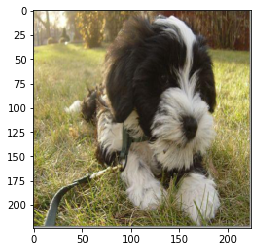

In [7]:
dog_imgs = ImageFolder('data/Images', transform = transforms.Compose(dog_transforms))
dog_loader = DataLoader(dog_imgs, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
visualize_one(dog_loader)

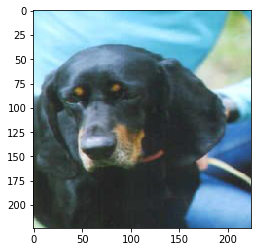

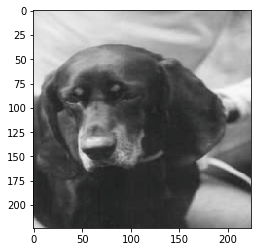

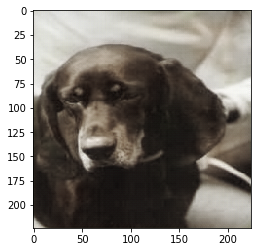

In [10]:
model = UNetWithResnet50Encoder().cuda()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001, epochs = 1, steps_per_epoch = 2573, final_div_factor = 1000)
lossf = nn.L1Loss()

losses = []
for i in range(1):
    start_time = time.perf_counter()
    for j, (x,_) in enumerate(dog_loader):
        x_gray = normalize(grayscale(x).unsqueeze(1).repeat(1,3,1,1).cuda())
        y = model(x_gray)
        loss = lossf(y, normalize(x.cuda()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())

        if j % 10 == 0: print_update(i,j,np.round(loss.item(), decimals = 4),len(dog_loader), start_time)
        if j == len(dog_loader) - 1 and display_train_visuals:
            visualize_tensor(x)
            visualize_tensor(x_gray, unnorm = True)
            visualize_tensor(y, unnorm = True)
#     print(np.mean(losses[-20:]))

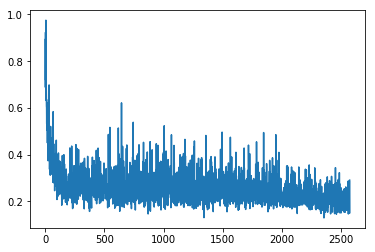

In [12]:
plt.plot(losses)
plt.show()

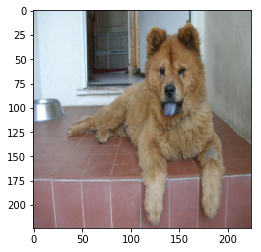

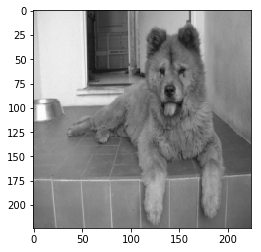

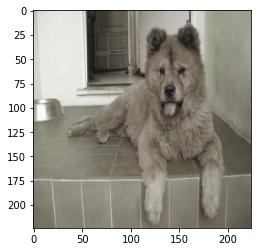

In [8]:
model = UNetWithResnet50Encoder().cuda()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001, epochs = 1, steps_per_epoch = 2573, final_div_factor = 1000)
lossf = VGGPerceptualLoss(resize = False).cuda()

losses = []
for i in range(1):
    start_time = time.perf_counter()
    for j, (x,_) in enumerate(dog_loader):
        x_gray = normalize(grayscale(x).unsqueeze(1).repeat(1,3,1,1).cuda())
        y = model(x_gray)
        loss = lossf(y, normalize(x.cuda()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())

        if j % 10 == 0: print_update(i,j,np.round(loss.item(), decimals = 4),len(dog_loader), start_time)
        if j == len(dog_loader) - 1 and display_train_visuals:
            visualize_tensor(x)
            visualize_tensor(x_gray, unnorm = True)
            visualize_tensor(y, unnorm = True)
#     print(np.mean(losses[-20:]))

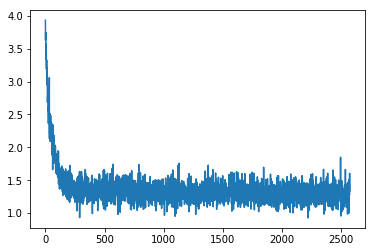

In [9]:
plt.plot(losses)
plt.show()